In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd,uproot as ur, awkward as ak
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rcParams["figure.figsize"] = (8, 8)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [2]:
#020176_pass08
#LD2+C
df_DC=ur.concatenate("rge_filtered/C/*.root:data")
#df_DC = ur.concatenate("clas12_data/rge_D_C/*.root:data")
df_DC['target']=np.full(len(df_DC),'D_C')

In [3]:
df_DCu =ur.concatenate("rge_filtered/Cu/*.root:data")
df_DCu['target']=np.full(len(df_DCu),'D_Cu')

In [4]:
df_H = ur.concatenate("clas12_data/rga_H/*.root:data")
df_H['target']=np.full(len(df_H),'H')

In [5]:
df=ak.concatenate([df_DC, df_DCu,df_H])

In [6]:
#df_DC.fields

In [7]:

df['has_electron']=ak.sum((df['REC::Particle::pid']==11)&(df['REC::Particle::status']<=-2000)&(df['REC::Particle::status']>-4000),axis=-1)==1
df['electron_vertex']=ak.sum(df['REC::Particle::vz']*(df['REC::Particle::pid']==11)*(df['REC::Particle::status']<-2000), axis=-1)

In [8]:
df['is_electron']=(df['REC::Particle::pid']==11)*(df['REC::Particle::status']<-2000)
df['E']=10.5473
df['delta_t']=ak.sum(df['REC::Particle::vt']*df['is_electron'], axis=-1)-1*df['REC::Particle::vt']
df['delta_z']=ak.sum(df['REC::Particle::vz']*df['is_electron'], axis=-1)-1*df['REC::Particle::vz']
df['nu']=df['E']-ak.sum(df['is_electron']*np.sqrt(df['REC::Particle::px']**2+df['REC::Particle::py']**2+df['REC::Particle::pz']**2),axis=-1)


zmin=0.80
df['is_leading_pion']=(abs(df['delta_t'])<.2)*(abs(df['delta_z'])<3)*\
    (df['REC::Particle::pid']==211)*\
    (np.sqrt(.1396**2+df['REC::Particle::px']**2+df['REC::Particle::py']**2+df['REC::Particle::pz']**2)>df['nu']*zmin)

df['has_leading_pion']=ak.sum(df['is_leading_pion'], axis=-1)>0

(array([  4999.,    631.,      0.,      0.,   2093.,  11040.,  18288.,
             0.,      0.,  15321., 235323.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

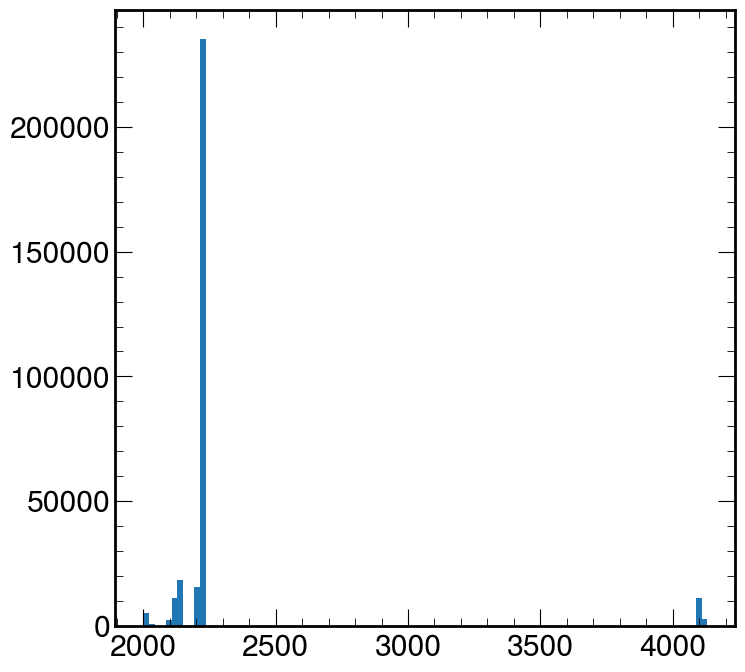

In [9]:
plt.hist(ak.flatten(df['REC::Particle::status'][df['is_leading_pion']]), bins=100)

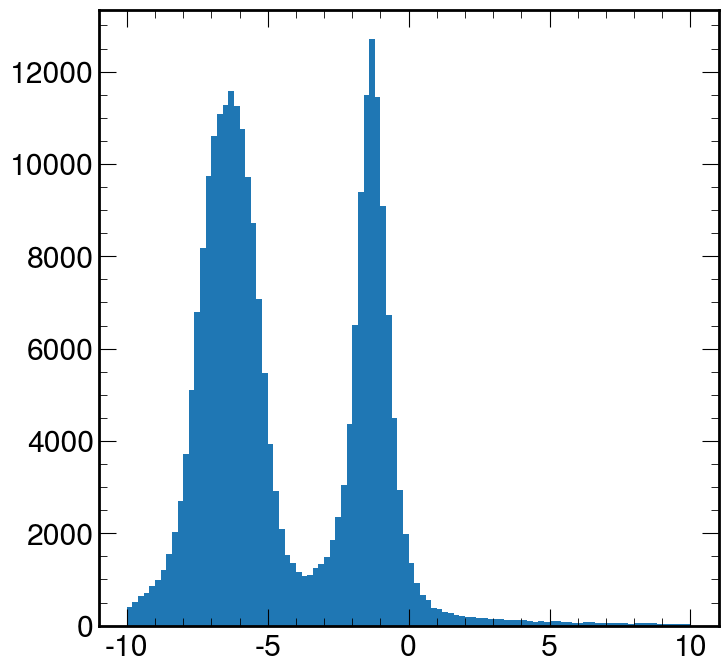

In [10]:
plt.hist(df['electron_vertex'][df['has_electron']&(df['nu']/df['E']<0.8)&(df.target=='D_C')], bins=100, range=(-10,10))
plt.show()

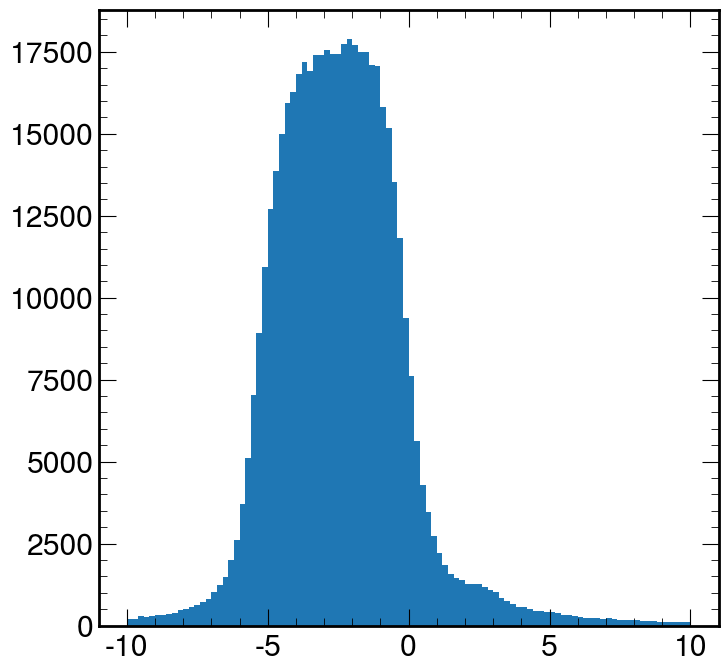

In [11]:
plt.hist(df['electron_vertex'][df['has_electron']&(df['nu']/df['E']<0.8)&(df.target=='H')], bins=100, range=(-10,10))
plt.show()

In [12]:
mp=0.9383
mD=1.875612945
mC=11.178
mCu=58.602
df['is_ST']=(df['electron_vertex']>-2)*(df['electron_vertex']<0)&((df['target']=='D_C') | (df['target']=='D_Cu'))
df['is_LT']=(df['electron_vertex']<-5)*(df['electron_vertex']>-8)&((df['target']=='D_C') | (df['target']=='D_Cu'))
df['is_H']=(df['electron_vertex']>-13)*(df['electron_vertex']<12)&(df['target']=='H')

df['is_C']=df.is_ST & (df.target=="D_C")
df['is_Cu']=df.is_ST & (df.target=="D_Cu")
df['is_D']=df.is_LT

df['M']=df.is_LT*mD+df.is_C*mC+df.is_Cu*mCu+(df.target=='H')*mp


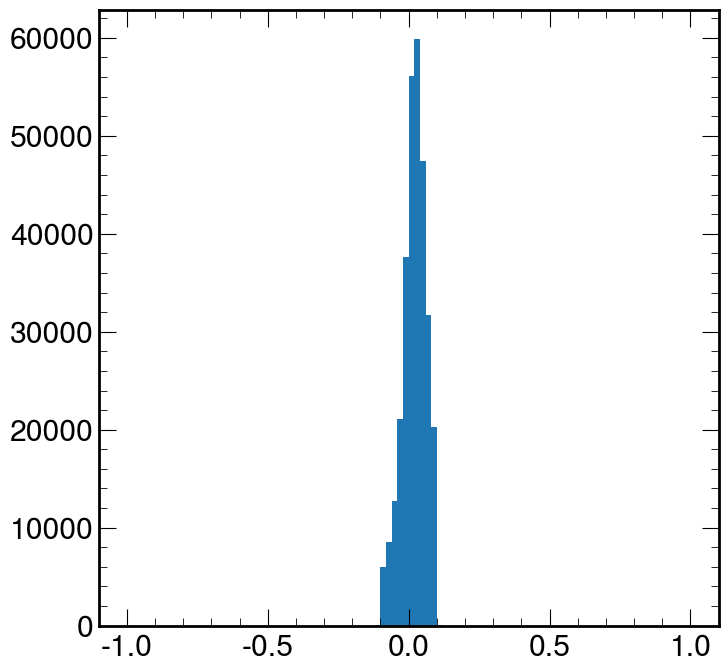

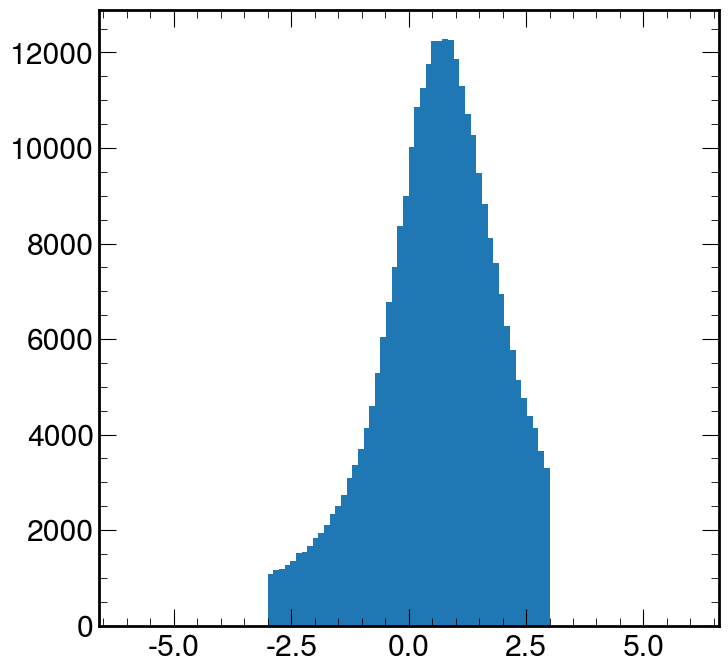

In [13]:

plt.hist(ak.flatten(df['delta_t'][df['has_electron']&df['is_leading_pion']]), bins=100, range=(-1,1))
plt.show()
plt.hist(ak.flatten(df['delta_z'][df['has_electron']&df['is_leading_pion']]), bins=100, range=(-6,6))
plt.show()

In [14]:
for a in 'xyz':
    df[f'pi_p{a}']=ak.sum(df[f'REC::Particle::p{a}']*df['is_leading_pion'], axis=-1)
    df[f'e_p{a}']=ak.sum(df[f'REC::Particle::p{a}']*df['is_electron'], axis=-1)
df['pi_E']=np.sqrt(.1396**2+df['pi_px']**2+df['pi_py']**2+df['pi_pz']**2)
df['e_E']=np.sqrt(.000511**2+df['e_px']**2+df['e_py']**2+df['e_pz']**2)
df['y']=(df.E-df.e_E)/df.E
df['Q2']=4*df.E*df.e_E*np.sin(np.arctan2(np.hypot(df.e_px,df.e_py),df.e_pz)/2)**2
df['x']=df.Q2/(2*.9383*df.nu)

In [15]:
#e+M-e'-pi

df['Mmiss']=np.sqrt((df['E']+df['M']-df['e_E']-df['pi_E'])**2\
                    -(-df['e_px']-df['pi_px'])**2
                    -(-df['e_py']-df['pi_py'])**2\
                    -(df['E']-df['e_pz']-df['pi_pz'])**2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


In [16]:
df['n_sec_pions']=ak.sum((np.abs(df['REC::Particle::pid'])>=211)&\
                    (np.abs(df['delta_t'])<0.2)&(abs(df['delta_z'])<3)&\
                    #(df['REC::Particle::chi2pid']<5)&\
                    (df['REC::Particle::status']>=2000)&\
                    (df['REC::Particle::status']<4000)&\
                    #(df['REC::Track::chi2']<100)&\
                    (np.sqrt(.1396**2+df['REC::Particle::px']**2+df['REC::Particle::py']**2+df['REC::Particle::pz']**2)/df['nu']<0.3),\
                    axis=-1)

In [17]:
missing_mass_cuts={('H', 5):1.5, ('D',5):2.7, ('C', 5):12.3, 
                   ('H', 6.5):1.4, ('D',6.5):2.7, ('C', 6.5):12.4,
                  ('H', 8.0):1.4, ('D',8.0):2.7, ('C', 8.0):12.4,
                  ('H', 9.5):1.4, ('D',9.5):2.7, ('C', 9.5):12.4}


/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_42048/2109444468.py:38: RuntimeWarning: invalid value encountered in divide
  ax2.plot(x[1:], (c1-c2*scale)/c1, color='tab:purple')


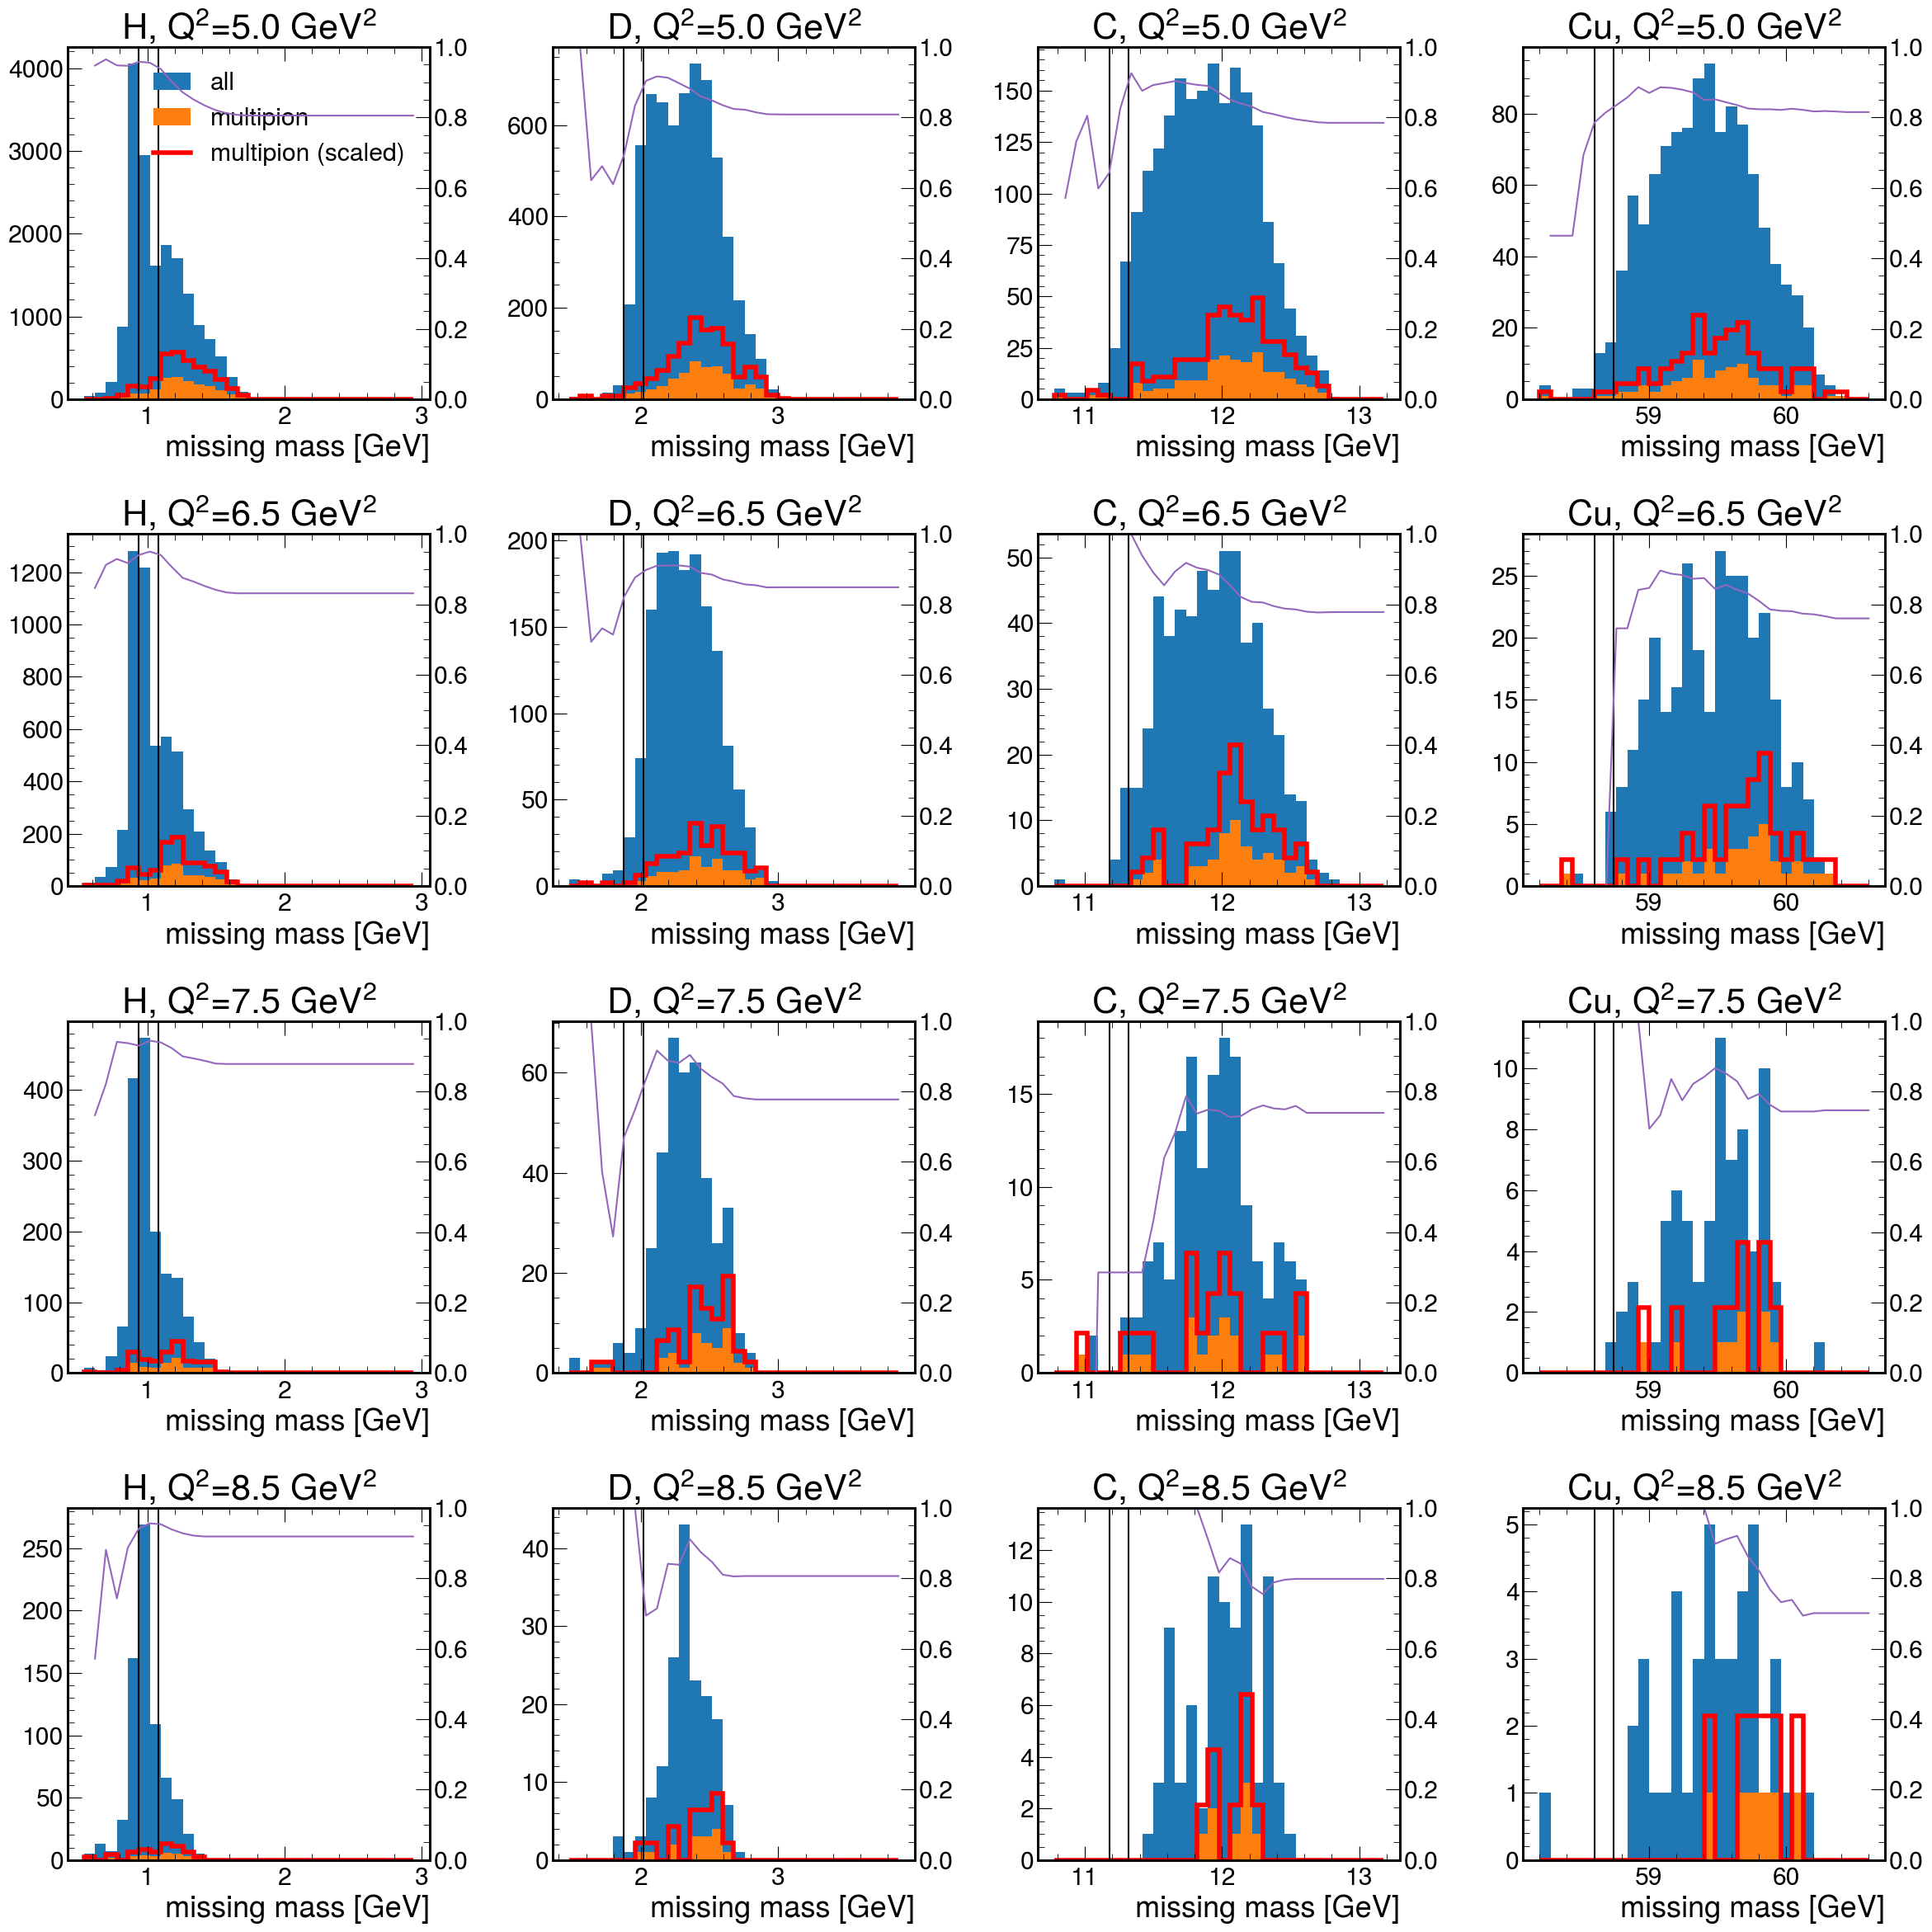

In [18]:
background_estimates={}
fig, axs=plt.subplots(4,4, figsize=(24, 24))
Q2min=(4.25, 5.75,7,8)
Q2max=(5.75,7,8,12)
for j,Q2 in enumerate((5.0, 6.5, 7.5, 8.5)):
    for i in 0,1,2,3:
        M=[mp,mD,mC,mCu][i]
        lbl='H D C Cu'.split()[i]
        plt.sca(axs[j][i])
        
        inQ2bin=(df.Q2>Q2min[j])&(df.Q2<Q2max[j])
        selection=df.has_leading_pion&df.has_electron&df[f"is_{lbl}"]&inQ2bin
        
        y1,x,_=plt.hist(df['Mmiss'][selection], bins=30,
                range=(M-.4, M+2), label='all')
        y,x,_=plt.hist(df['Mmiss'][selection&(df['n_sec_pions']>0)], bins=30,
                range=(M-.4, M+2), label='multipion')
        scale=3/2/.7
        plt.stairs(y*scale, x, color='r', label="multipion (scaled)", alpha=1, lw=4)

        from itertools import accumulate
        
        
        plt.axvline(M, color='k')
        plt.axvline(M+.1396, color='k')
        #plt.axvline(missing_mass_cuts[(lbl, Q2)], color='k')
        plt.xlabel("missing mass [GeV]")
        
        plt.title(f"{lbl}, $Q^2$={Q2} GeV$^2$")

        n,d=np.sum(y),np.sum(y1)
        background_estimates[(lbl,Q2)]=(n*scale/d,np.sqrt(max(n,1)*max(d-n,1)/d**3)*scale)

        # Cumulative sum
        c1 = np.array(list(accumulate(y1)))
        c2 = np.array(list(accumulate(y)))
        ax2=plt.gca().twinx()
        ax2.plot(x[1:], (c1-c2*scale)/c1, color='tab:purple')
        ax2.set_ylim(0,1)
        
        #plt.savefig(f"dipion_{lbl}_{Q2}.pdf")
axs[0][0].legend()
fig.tight_layout()
plt.show()      
    
            

(0.0, 42.9534963935429)

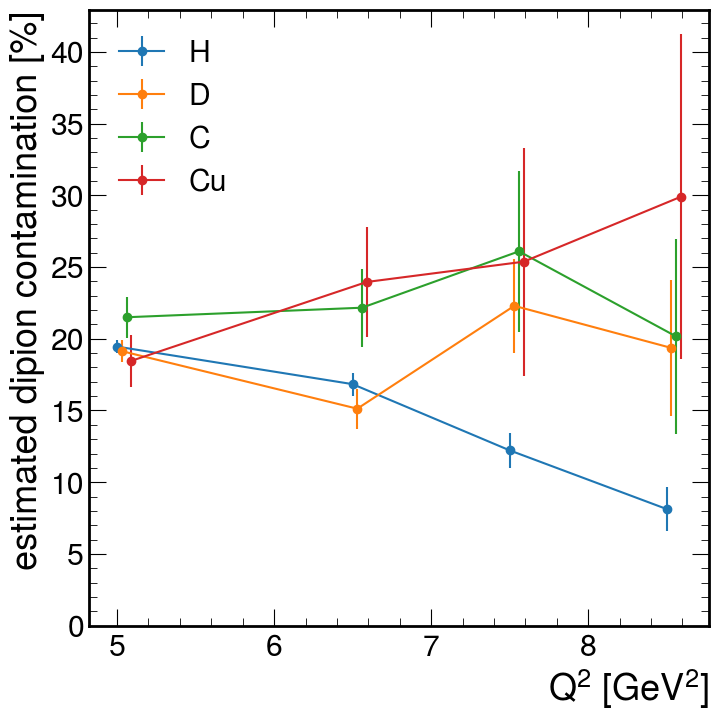

In [20]:
for i, target in enumerate("H D C Cu".split()):
    Q2vals=np.array((5.0, 6.5, 7.5, 8.5))
    f,dfrac=(np.array([background_estimates[(target,Q2)][a] for Q2 in Q2vals]) for a in (0,1))
    plt.errorbar(Q2vals+i*.03, 100*f,100*dfrac, label=target, marker='o')
    
plt.xlabel("$Q^2$ [GeV$^2$]")
plt.ylabel("estimated dipion contamination [%]")
plt.legend()
plt.ylim(0)

In [27]:
import gc; gc.collect()

11848